# Inferring the average size of a raindrop with buckets and SBI
A tutorial for the AI for Science workshop 
by Kyle Cranmer, July, 2025

## A puzzle

Imagine that you are equipped with several buckets and stop watches, can you find a way to measure the average size of a raindrop?

!['made by KC with ChatGPT'](./rain_bucket.jpg)

Maybe you are thinking that if you only put the buckets out in the rain for a short period of time you can catch just a few rain drops and then look at the differences in the volume of water collected in the buckets that would correspond to the volume of one rain drop. Ok, maybe, but that doesn't seem very practical. You'd have a hard time avoiding some of the water to stick to the buckets etc. Is there another way? Hint... probability and statistics!

## A degeneracy

After thinking a bit, maybe you keep running into the problem that there is a degeneracy betwen the number of rain drops, $n_{\rm drops}$, and the size of an individual drop, $\bar{v}_{\rm drop}$ leading to the same volume of water, $V$, in a bucket.

\begin{equation}
V = n_{\rm drops} \bar{v}_{\rm drop}
\end{equation}

It's not very practical to try to count the number of rain drops, so that's not the answer.

## Breaking the degeneracy

This is where having multiple buckets comes in. If we assume that the flux of rain drops ($f$) (number of rain drops per second per square-meter) is uniform (which seems safe) and that the buckets have the same area ($A$) and they are all put out in the rain for the same amount of time $T$, then the *expected number* of rain drops in each bucket should be the same ($n_{exp} = f T A$). But will they be exactly the same? No! Why not? Because there are random fluctuations! 

We can see the number of rain drops in each bucket as random samples from some probability distribution. What is that probability distribution? It's our friend, the Poisson distribution.
\begin{equation}
n_{\rm drops} \sim \textrm{Pois}( n_{exp} = f T A) )
\end{equation}

Ok, fine, but how does that help us? Well, one of the important properties of the Poisson distribution is that its variance is equal to its expectation: $\textrm{std}[n_{\rm drops}] = n_{exp}$). So if $T$ and $A$ are constant, then the only source of variance comes from Poisson fluctuations and the variance gives us another handle on $n_{exp}$. Equivalently, the  "relative error" (standard deviation / mean) is $\textrm{std}[n_{\rm drops}]/\textrm{mean}[n_{\rm drops}] = 1/\sqrt{n_{exp}}$. So narrower distributions correspond to larger $n_{exp}$. 


Let's say that we have $N_{\rm buckets}$ buckets and the volume in each bucket is $V_i$, where $i$ is the index over buckets. To make the notation less cumbersome, let $n_i$ be the number of drops in the $i^{th}$ bucket and $\bar{v}$ be the average volume of a single rain drop. Then we have $V_i = n_i \bar{v}$.

So if we look at the relative spread in across volume of water in multiple buckets, we will see:
\begin{equation}
\frac{\textrm{std}[\{V_i\}]}{\textrm{mean}[\{V_i\}]}
= \frac{\sqrt{n_{exp}} \bar{v}}{n_{exp} \bar{v}} 
= \frac{1}{\sqrt{n_{exp}}}
\end{equation}
The unknown average volume $\bar{v}$ cancels out, so this breaks the degeneracy!

## Estimating the size of a raindrop

So by measuring the volume of water in multiple buckets $\{V_1, \dots, V_{N_{buckets}}\}$ we can calculate both the sample mean and sample standard deviation, which lets us estimate $n_{exp}$ as
\begin{equation}
\hat{n}_{exp} = \left( \frac{\textrm{mean}[\{V_i\}]}{\textrm{std}[\{V_i\}]} \right)^2
\end{equation}

Once we have an estimate of $n_{exp}$, then we can estimate the average volume of a rain drop simply as the average volume in the buckets divided by the expected number of drops in the bucket:
\begin{equation}
\hat{\bar{v}} = \frac{\textrm{mean}[\{V_i\}]}{\hat{n}_{exp}} = \frac{\textrm{std}[\{V_i\}]^2}{\textrm{mean}[\{V_i\}]} 
\end{equation}

Pretty cool!

## Adding some more realism

So that's a great story, and we will try it out below. But let's add a little more realism. One obvious thing is that we can't measure the volume of water in the buckets perfectly. Let's say that we have some (Gaussian) measurement uncertainty (aka "measurement error"), so what we observe is 
\begin{equation}
V_{i, obs} \sim N(V_i, \sigma_v) \; ,
\end{equation}
where $N(\mu,\sigma)$ is a normal distribution. 

Will this spoil our measurement? The additional measurement error will broaden the distribution, which will bias our estimate for the number of drops to be too small (because the relative error is larger for smaller $n$), which will in turn bias our estimate for the volume of drops to be too large. 

Can we take this effect into account? Yes, we can design a more sophisticated estimator that takes this into account. Without going into it in too much detail, if the number of rain drops is large then the Poisson distribution is well approximated by a Gaussian and the effect of measurement 'error' is a convolution of two Gaussians, so you get an updated formulae for $\textrm{std}[\{V_i\}] = \sqrt{ n_{exp} \bar{v}^2 + \sigma_v^2 }$, you do some algebra and you get
\begin{equation}
\hat{\bar{v}}_{improved} = \frac{\textrm{mean}[\{V_i\}]}{\hat{n}_{exp}} = \frac{\textrm{std}[\{V_i\}]^2 - \sigma_v^2}{\textrm{mean}[\{V_i\}]} 
\end{equation}

## Hand-designed estimators vs. Simulation-based Inference

This becomes a great example for many areas of science where we use our insight into the physical situation to hand-design more sophisticated estimates and summary statistics. But as we continue to add realism and complexity to our forward model / simulation of the data-generating process (fancy words for some buckets in the rain), the math will get tricker and tricker and we may have to make more approximations. This is where simulation-based inference (SBI) can be helpful. SBI provides a fairly generic numerical approach to this inference problem that doesn't rely on hand-designed summary statistics or estimators. On one hand you loose some of the interpretability of the hand-designed estimators, but on the other you avoid some of their pitfalls (e.g. introducing bias, loosing power, making overly complicated estimators that noone can follow, etc.). 

## The rest of the tutorial

So in the rest of the tutorial below, let's:
 1. make a simple forward model / simulator for the buckets in the rain (that takes into account measurement uncertainty on the volume of water in the buckets)
 2. let's see how well the simple estimator and the improved estimator work on synthetic data
 3. let's try SBI using the `sbi` package without deriving any hand-designed estimators
   a. first using the mean and standard deviation as summary statistics
   b. and second using the raw data $\{V_i\}$

Since SBI will give us a full Bayesian posterior, we won't just have a point estimate, we will also see a posterior that reveals the approximate degeneracy between the flux and the raindrop size.

Then as a stretch goal, we can imagine a more complicated simulator / forward model that includes more effects, such as:
 1. not all of the buckets are exposed to the rain for the same ammount of time, and we have uncertainty on our measurements $T_i$
 2. not all of the buckets have the same area, and we have uncertainty on our measurements $A_i$
 3. The rain drops themselves aren't all the same size, but they vary according to some intrensic distribution of raindrop sizes

In this more complicated situation, the data will grow to $\{V_i, A_i, T_i\}$, the model can have multiple nuisance parameters (e.g. flux of rain, intrensic spread of rain drop sizes). Deriving an estimator for $\bar{v}$ in this case gets much tougher, but SBI should still work. 


# Create a simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Some Global Parameters for the simulator

# number of buckets
n_buckets = 30

# bucket area in m^2
bucket_area = 0.25

# target exposure time in seconds
t_exp = 600

# uncertainty in volume measurement in mL
V_uncert = 12.5

In [3]:
def rain_bucket_simple_simulator(flux, v_drop):
    ''' 
     flux in drops / sec / meter^2
     v_drop in mL 
    '''
    n_drops = np.random.poisson(flux * t_exp * bucket_area, size=n_buckets)
    V_true = n_drops*v_drop
    V_obs = np.random.normal(V_true, V_uncert)
    return V_obs

In [4]:
# see derivation in text above
def naive_estimate(V_obs):
    std_v = np.std(V_obs)
    v_drop = np.mean(V_obs)
    # rel_error = 1/sqrt(N)
    # N = 1/rel_error^2
    n_drops_est = (v_drop/std_v)**2
    v_drop_est = v_drop / n_drops_est
    return v_drop_est

In [5]:
# see derivation in text above
def improved_estimate(V_obs):
    std_v = np.std(V_obs)
    v_drop = np.mean(V_obs)
    # uncert^2 = sqrt(N)^2 + V_uncert^2
    # uncert = sqrt(N + V_uncert^2)
    # rel_error = uncert / N*v_drop_est
    # v_drop_est = 
    # N = 1/rel_error^2
    n_drops_est = v_drop**2/(std_v**2-V_uncert**2)
    v_drop_est = v_drop / n_drops_est
    return v_drop_est

## Generate two example datasets with the same average volume in buckets 
This is a seemingly degenerate scenario, but vairance will be different

In [6]:
V_obs_a = rain_bucket_simple_simulator(flux = 10, v_drop = 0.01)
V_obs_b = rain_bucket_simple_simulator(flux = 1, v_drop = 0.1)

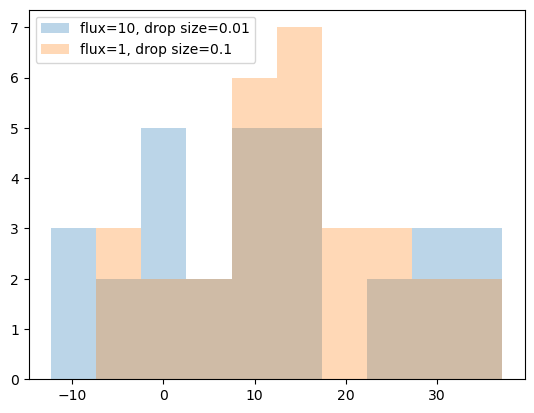

In [7]:
counts, bins, _ = plt.hist(V_obs_a, alpha=.3, label='flux=10, drop size=0.01')
_ = plt.hist(V_obs_b, bins=bins, alpha=.3, label='flux=1, drop size=0.1')
plt.legend()

In [8]:
naive_estimate(V_obs_a), improved_estimate(V_obs_a)

(18.140689134497837, 4.0041644955569735)

In [9]:
naive_estimate(V_obs_b), improved_estimate(V_obs_b)

(8.074747646942031, -2.9561830351111507)

# Generate a large number of simulations with different flux and drop size

We will use this for both evaluating the hand-designed estimators and for training SBI 

In [10]:
n_train = 5000
# flux range
flux_min, flux_max = 1.,20.
# v_drop range
v_drop_min, v_drop_max = 0.01, .5

# sample from proposal for where to run simulator
flux_samples = np.random.uniform(flux_min, flux_max, size=n_train)
v_drop_samples = np.random.uniform(v_drop_min, v_drop_max, size=n_train)

V_obs_samples = np.zeros((n_train,n_buckets))
naive_estimates = np.zeros(n_train)
improved_estimates = np.zeros(n_train)

for i in range(n_train):
    V_obs_samples[i] = rain_bucket_simple_simulator(flux = flux_samples[i], v_drop = v_drop_samples[i])
    naive_estimates[i] =  naive_estimate(V_obs_samples[i])
    improved_estimates[i] =  improved_estimate(V_obs_samples[i])


### Visualize the performance of the estimators
Notice the naive estimator is biased towards drop sizes that are too large. Improved estimator is doing better.

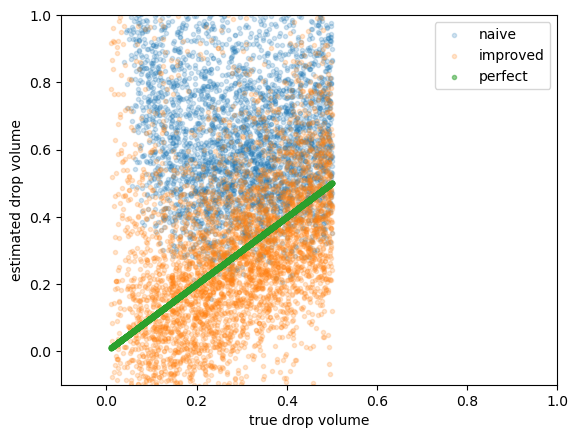

In [11]:
plt.scatter(v_drop_samples,naive_estimates, alpha=.2, marker='.', label='naive')
plt.scatter(v_drop_samples,improved_estimates, alpha=.2, marker='.', label='improved')
plt.scatter(v_drop_samples,v_drop_samples, alpha=.5, marker='.', label='perfect')
plt.xlim(-.1,2*v_drop_max)
plt.ylim(-.1,2*v_drop_max)
plt.xlabel('true drop volume')
plt.ylabel('estimated drop volume')
plt.legend()

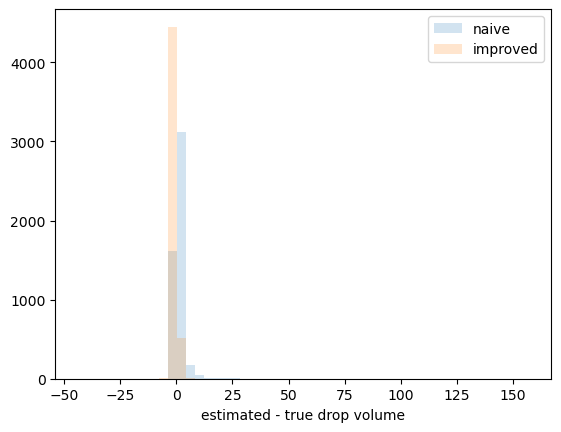

In [12]:
# look at residuals
counts, bins, _ = plt.hist(naive_estimates-v_drop_samples, bins=50, alpha=.2, label='naive')
counts, bins, _ = plt.hist(improved_estimates-v_drop_samples, bins=bins, alpha=.2, label='improved')
plt.xlabel('estimated - true drop volume')
plt.legend()

# Now try with Simulation-Based Inference

This part follows `sbi`'s [Getting Started](https://sbi.readthedocs.io/en/latest/tutorials/00_getting_started.html) tutorial very closely.

### Prepare training data with (parameters, raw observations) and (parameters, summaries)

In [13]:
import torch

In [14]:
# repackage parameter values used in simulator as a torch tensor for training
params_samples = torch.tensor(np.vstack((flux_samples, v_drop_samples)).T,dtype=torch.float)

#repackage observations from simulator as a torch tensor for training
obs_samples = torch.tensor(V_obs_samples, dtype=torch.float)

In [15]:
# calculate summaries, package as torch tensors
mean_summary = torch.tensor(np.mean(V_obs_samples,axis=1),dtype=torch.float)
std_summary = torch.tensor(np.std(V_obs_samples,axis=1),dtype=torch.float)
summaries = torch.vstack((mean_summary, std_summary)).T

### Create the prior

In [16]:
from sbi.utils import BoxUniform

In [17]:
num_params = 2
prior = BoxUniform(low=torch.tensor((flux_min,v_drop_min)), high=torch.tensor((flux_max,v_drop_max)))

## Create two Neural Posterior Estimator objects for inference with and without summaries

In [18]:
from sbi.inference import NPE

inference_w_raw_obs = NPE(prior=prior)
inference_w_summaries = NPE(prior=prior)

In [19]:
inference_w_raw_obs = inference_w_raw_obs.append_simulations(params_samples, obs_samples)
inference_w_summaries = inference_w_summaries.append_simulations(params_samples, summaries)

In [20]:
posterior_estimator_w_raw_obs = inference_w_raw_obs.train()
posterior_estimator_w_summaries = inference_w_summaries.train()

 Neural network successfully converged after 60 epochs.

In [21]:
# Create posterior objects
posterior_w_raw_obs = inference_w_raw_obs.build_posterior()
posterior_w_summaries = inference_w_summaries.build_posterior()

### Create a an example observation for some ground truth scenario

In [22]:
ground_truth_flux = 10.
ground_truth_v_drop = 0.2 
x_obs = torch.tensor(rain_bucket_simple_simulator(flux = ground_truth_flux, v_drop = ground_truth_v_drop),dtype=torch.float)
summary_obs = torch.as_tensor([torch.mean(x_obs), torch.std(x_obs)], dtype=torch.float)

In [23]:
posterior_samples_w_raw_obs = posterior_w_raw_obs.sample((10000,), x=x_obs)
posterior_samples_w_summaries = posterior_w_summaries.sample((10000,), x=summary_obs)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

### Visualize result with summaries

In [24]:
# set default observation for MAP below
posterior_w_summaries.set_default_x(summary_obs)
map_summaries = posterior_w_summaries.map() 
print('ground truth : MAP flux = {} : {}'.format(ground_truth_flux, map_summaries[0,0]))
print('ground truth : MAP drop size = {} : {}'.format(ground_truth_v_drop, map_summaries[0,1]))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

ground truth : MAP flux = 10.0 : 9.810065269470215
ground truth : MAP drop size = 0.2 : 0.20476479828357697


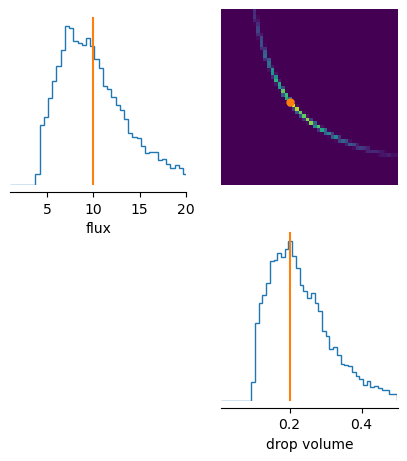

In [25]:
from sbi.analysis import pairplot

_ = pairplot(
    posterior_samples_w_summaries,
    points=np.array((10,0.2)),
    limits=[[flux_min, flux_max], [v_drop_min, v_drop_max]],
    figsize=(5, 5),
    labels=[r"flux", r"drop volume"]
)

### Visualize result with raw observatons

In [26]:
# set default observation for MAP below
posterior_w_raw_obs.set_default_x(x_obs)
map_raw = posterior_w_raw_obs.map() # seems like this is MAP for each 1-d marginal? Not sure.
print('ground truth : MAP flux = {} : {}'.format(ground_truth_flux, map_raw[0,0]))
print('ground truth : MAP drop size = {} : {}'.format(ground_truth_v_drop, map_raw[0,1]))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

ground truth : MAP flux = 10.0 : 9.171217918395996
ground truth : MAP drop size = 0.2 : 0.218437060713768


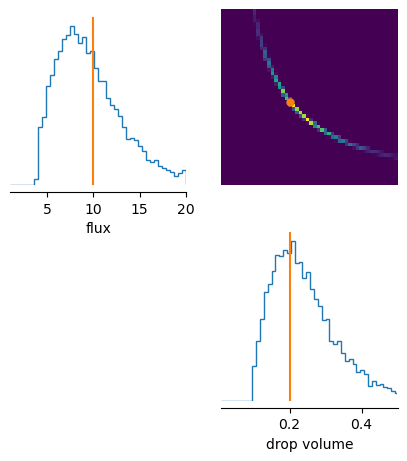

In [27]:
from sbi.analysis import pairplot

_ = pairplot(
    posterior_samples_w_raw_obs,
    points=np.array((10,0.2)),
    limits=[[flux_min, flux_max], [v_drop_min, v_drop_max]],
    figsize=(5, 5),
    labels=[r"flux", r"drop volume"]
)

See some bias in the posterior. May need more training data when working with raw observations

# Create a more complicated simulator - TBD

In [28]:
# Create a more compliated simulator

In [29]:
## more complicated model

# uncertainty in time exposure measurement in seconds
t_uncert = 0.1

# relative fluctuation in volume of rain drops (std. dev / mean)
sigma_v_over_v = 0.1

# standard devaition of exposure time in seconds
sigma_t = 1.
